# Cycle 2 Evaluation Notebook (Local Data)

This notebook compares the results of **Cycle 1 (Baseline)** vs **Cycle 2 (Active Learning)**.
It reads data from local CSV files `cycle1_full.csv` and `cycle2_full.csv`.

## 1. Setup & Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Check if files exist
import os
if not os.path.exists('cycle1_full.csv') or not os.path.exists('cycle2_full.csv'):
    print("WARNING: Ensure 'cycle1_full.csv' and 'cycle2_full.csv' are in the same directory.")
else:
    print("Files found. Ready to load.")

Files found. Ready to load.


## 2. Load Data

In [2]:
# DATA LOADING 
#
df1 = pd.read_csv('cycle1_full.csv')
df1['Cycle'] = 'Cycle 1'

df2 = pd.read_csv('cycle2_full.csv')
df2['Cycle'] = 'Cycle 2'

df_all = pd.concat([df1, df2], ignore_index=True)

## 3. Summary Statistics

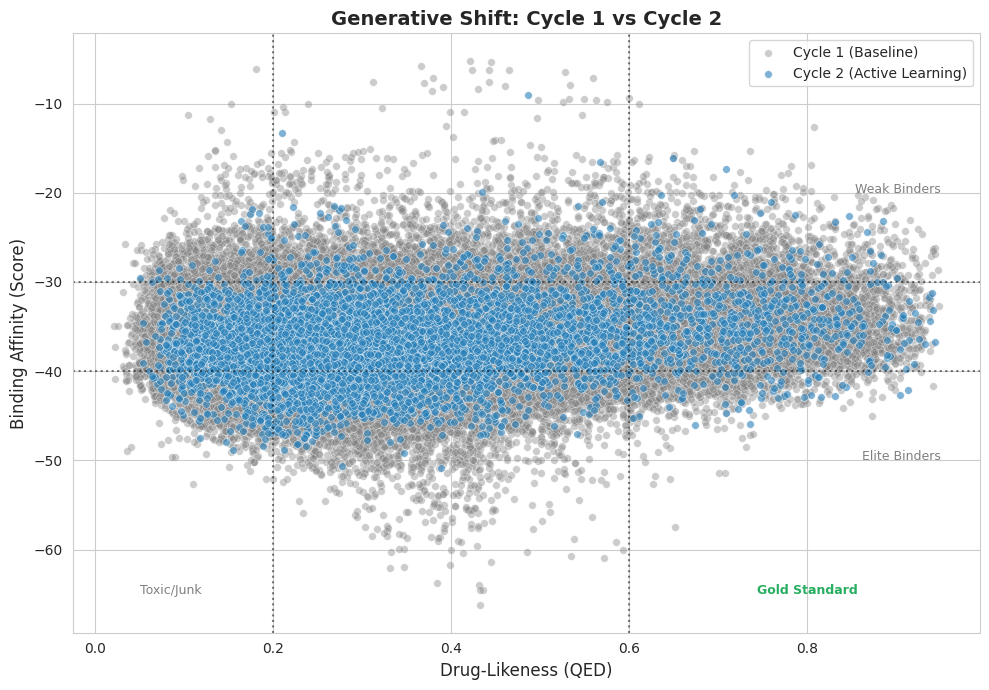

DISTRIBUTION REPORT: GENERATIVE MODEL SHIFT
Metric                              | Cycle 1      | Cycle 2      | Shift       
---------------------------------------------------------------------------
BINDING AFFINITY                    | (N=70259)    | (N=6853)     |
---------------------------------------------------------------------------
Strong Binders (< -40)              |      23.30% |      22.19% |      -1.10%
Medium Binders (-30 to -40)         |      68.83% |      72.26% |      +3.43%
Weak Binders (> -30)                |       7.87% |       5.55% |      -2.32%
---------------------------------------------------------------------------
QED PROFILE                         |              |              |
---------------------------------------------------------------------------
High QED (> 0.6)                    |      11.92% |      11.13% |      -0.78%
Medium QED (0.2 - 0.6)              |      63.84% |      68.67% |      +4.83%
Low QED (< 0.2)                     |      24

In [6]:


# STATISTICAL CALCULATIONS 
def calculate_stats(df, cycle_name):
    total = len(df)
    if total == 0: return {}
    
    # Affinity Bins (Lower is Better)
    strong_bind = len(df[df['final_score'] < -40])
    med_bind = len(df[(df['final_score'] >= -40) & (df['final_score'] <= -30)])
    weak_bind = len(df[df['final_score'] > -30])
    
    # QED Bins (Higher is Better)
    high_qed = len(df[df['qed_score'] > 0.6])
    med_qed = len(df[(df['qed_score'] >= 0.2) & (df['qed_score'] <= 0.6)])
    low_qed = len(df[df['qed_score'] < 0.2])
    
    return {
        'cycle': cycle_name,
        'strong_pct': (strong_bind/total)*100,
        'med_pct': (med_bind/total)*100,
        'weak_pct': (weak_bind/total)*100,
        'high_qed_pct': (high_qed/total)*100,
        'med_qed_pct': (med_qed/total)*100,
        'low_qed_pct': (low_qed/total)*100,
        'total': total
    }

stats_c1 = calculate_stats(df1, "Cycle 1")
stats_c2 = calculate_stats(df2, "Cycle 2")

# --- 3. THE PLOT ---
plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")

# Plot Cycle 1 first (Grey/Background)
sns.scatterplot(
    data=df1, x='qed_score', y='final_score', 
    color='grey', label='Cycle 1 (Baseline)', alpha=0.4, s=30
)

# Plot Cycle 2 on top (Blue/Focus)
sns.scatterplot(
    data=df2, x='qed_score', y='final_score', 
    color='#2980b9', label='Cycle 2 (Active Learning)', alpha=0.6, s=30
)

# Add Threshold Lines
plt.axhline(y=-30, color='black', linestyle=':', alpha=0.5)
plt.axhline(y=-40, color='black', linestyle=':', alpha=0.5)
plt.axvline(x=0.2, color='black', linestyle=':', alpha=0.5)
plt.axvline(x=0.6, color='black', linestyle=':', alpha=0.5)

# Annotations for Zones
plt.text(0.95, -20, "Weak Binders", ha='right', fontsize=9, color='grey')
plt.text(0.95, -50, "Elite Binders", ha='right', fontsize=9, color='grey')
plt.text(0.05, -65, "Toxic/Junk", ha='left', fontsize=9, color='grey')
plt.text(0.80, -65, "Gold Standard", ha='center', fontsize=9, fontweight='bold', color='#27ae60')

plt.title('Generative Shift: Cycle 1 vs Cycle 2', fontsize=14, fontweight='bold')
plt.xlabel('Drug-Likeness (QED)', fontsize=12)
plt.ylabel('Binding Affinity (Score)', fontsize=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('cycle_comparison_scatter.png')
plt.show()


# --- 4. THE REPORT TEXT (Tabular Format) ---

print("="*80)
print("DISTRIBUTION REPORT: GENERATIVE MODEL SHIFT")
print("="*80)
print(f"{'Metric':<35} | {'Cycle 1':<12} | {'Cycle 2':<12} | {'Shift':<12}")
print("-" * 75)

# 1. BINDING AFFINITY SECTION
print(f"{'BINDING AFFINITY':<35} | {'(N='+str(stats_c1['total'])+')':<12} | {'(N='+str(stats_c2['total'])+')':<12} |")
print("-" * 75)

affinity_metrics = [
    ("Strong Binders (< -40)", 'strong_pct'),
    ("Medium Binders (-30 to -40)", 'med_pct'),
    ("Weak Binders (> -30)", 'weak_pct')
]

for label, key in affinity_metrics:
    val1 = stats_c1[key]
    val2 = stats_c2[key]
    diff = val2 - val1
    print(f"{label:<35} | {val1:>10.2f}% | {val2:>10.2f}% | {diff:>+10.2f}%")

print("-" * 75)

# 2. QED (DRUG-LIKENESS) SECTION
print(f"{'QED PROFILE':<35} | {'':<12} | {'':<12} |")
print("-" * 75)

qed_metrics = [
    ("High QED (> 0.6)", 'high_qed_pct'),
    ("Medium QED (0.2 - 0.6)", 'med_qed_pct'),
    ("Low QED (< 0.2)", 'low_qed_pct')
]

for label, key in qed_metrics:
    val1 = stats_c1[key]
    val2 = stats_c2[key]
    diff = val2 - val1
    print(f"{label:<35} | {val1:>10.2f}% | {val2:>10.2f}% | {diff:>+10.2f}%")

print("="*80)

# Optional: Keep the Fold Change Conclusion
if stats_c1['strong_pct'] > 0:
    fold_change = stats_c2['strong_pct'] / stats_c1['strong_pct']
    print(f"CONCLUSION: The proportion of Strong Binders increased by {fold_change:.1f}x.")
else:
    print("")
print("="*80)

Debug: Safety Counts after fix:
toxicity_label
Safe       71293
Toxic       5817
Unknown        2
Name: count, dtype: int64
------------------------------


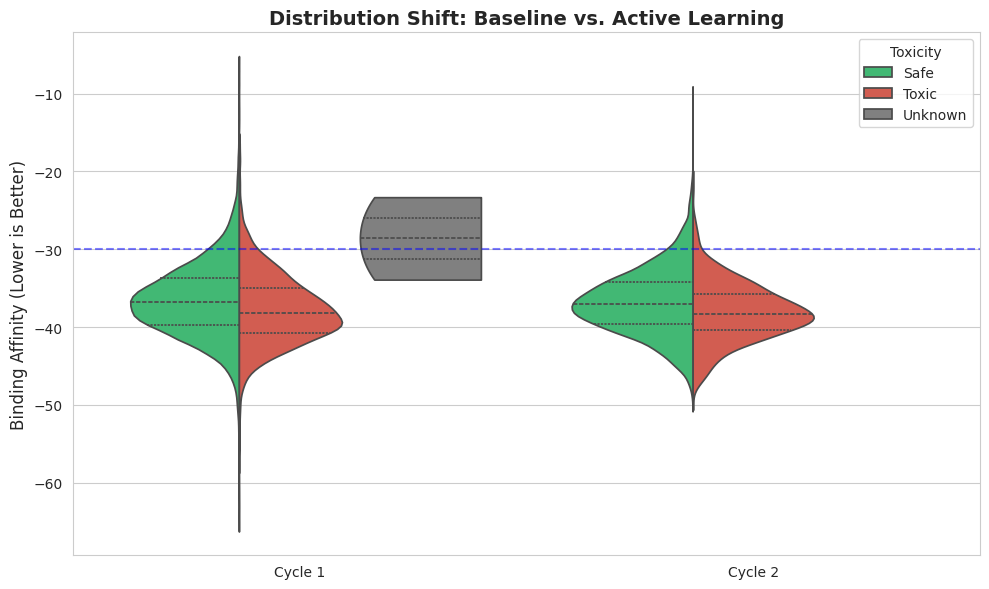

PERFORMANCE REPORT: CYCLE 1 vs CYCLE 2
Metric                    | Cycle 1      | Cycle 2      | Improvement 
---------------------------------------------------------------------------
Total Molecules           | 70259        | 6853         | -63406      
Mean Affinity *           | -36.68       | -36.89       | -0.21       
Median Affinity *         | -36.91       | -37.11       | -0.20       
Hit Rate (<-30)           | 92.13%       | 94.45%       | +2.32%      
Elite Rate (<-40)         | 23.30%       | 22.19%       | -1.10%      
Mean QED                  | 0.35         | 0.35         | +0.00       
Safety Rate (% Safe)      | 92.57%       | 91.27%       | -1.30%      
GOLD CANDIDATES           | 59771        | 5889         | -53882      
Gold Rate (%)             | 85.07%       | 85.93%       | +0.86%      
* Notes: Lower is better for Affinity scores


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. DATA LOADING ---
# Load Cycle 1
df1 = pd.read_csv('cycle1_full.csv')
df1['Cycle'] = 'Cycle 1'

# Load Cycle 2
df2 = pd.read_csv('cycle2_full.csv')
df2['Cycle'] = 'Cycle 2'

# Combine
df_all = pd.concat([df1, df2], ignore_index=True)

# --- 2. TOXICITY LABELS ---
# Force column to numeric (handles strings "0", floats 0.0, and ints 0)
df_all['toxicity_label'] = pd.to_numeric(df_all['toxicity_label'], errors='coerce')

# Now map 0 -> Safe, 1 -> Toxic (handle NaNs as 'Unknown')
toxicity_map = {0: 'Safe', 1: 'Toxic'}
df_all['toxicity_label'] = df_all['toxicity_label'].map(toxicity_map).fillna('Unknown')

# Debug print to confirm fix
print("Debug: Safety Counts after fix:")
print(df_all['toxicity_label'].value_counts())
print("-" * 30)

# --- 3. THE VISUAL (Violin Plot) ---
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create Violin Plot
ax = sns.violinplot(
    data=df_all,
    x='Cycle',
    y='final_score',
    hue='toxicity_label',
    palette={'Safe': '#2ecc71', 'Toxic': '#e74c3c', 'Unknown': 'grey'},
    split=True,       # Split violin to see Safe vs Toxic side-by-side
    inner='quartile', # Show median/quartiles
    cut=0             # Don't extrapolate past data limits
)

plt.title('Distribution Shift: Baseline vs. Active Learning', fontsize=14, fontweight='bold')
plt.ylabel('Binding Affinity (Lower is Better)', fontsize=12)
plt.xlabel('')
plt.legend(title='Toxicity')
plt.axhline(y=-30, color='blue', linestyle='--', alpha=0.5, label='Hit Threshold (-30)')

plt.tight_layout()
plt.savefig('plot2_comparison_violin.png')
plt.show()

# --- 4. THE SIDE-BY-SIDE TABLE GENERATOR ---

def get_cycle_metrics(df):
    """Calculates a dictionary of key metrics for a given dataframe."""
    total = len(df)
    if total == 0: return {}
    
    # -- Affinity Metrics --
    mean_score = df['final_score'].mean()
    median_score = df['final_score'].median()
    
    # Hit Rates
    hits_30 = len(df[df['final_score'] < -30])
    hits_40 = len(df[df['final_score'] < -40])
    
    # -- Quality Metrics --
    mean_qed = df['qed_score'].mean()
    safe_count = len(df[df['toxicity_label'] == 'Safe'])
    
    # -- The "Golden" Metric: Safe AND Strong Binder --
    # (Score < -30 AND Safe)
    gold_hits = len(df[(df['final_score'] < -30) & (df['toxicity_label'] == 'Safe')])
    
    metrics = {
        'Total Molecules': total,
        'Mean Affinity *': mean_score,
        'Median Affinity *': median_score,
        'Hit Rate (<-30)': (hits_30 / total) * 100,
        'Elite Rate (<-40)': (hits_40 / total) * 100,
        'Mean QED': mean_qed,
        'Safety Rate (% Safe)': (safe_count / total) * 100,
        'GOLD CANDIDATES': gold_hits,
        'Gold Rate (%)': (gold_hits / total) * 100
    }
    
    return metrics

# Calculate metrics
metrics_c1 = get_cycle_metrics(df_all[df_all['Cycle'] == 'Cycle 1'])
metrics_c2 = get_cycle_metrics(df_all[df_all['Cycle'] == 'Cycle 2'])

# Create DataFrame for display
comparison_df = pd.DataFrame({
    'Metric': metrics_c1.keys(),
    'Cycle 1': metrics_c1.values(),
    'Cycle 2': metrics_c2.values()
})

# Calculate Delta
comparison_df['Delta'] = comparison_df['Cycle 2'] - comparison_df['Cycle 1']

# Print Formatted Table
print("="*80)
print("PERFORMANCE REPORT: CYCLE 1 vs CYCLE 2")
print("="*80)
print(f"{'Metric':<25} | {'Cycle 1':<12} | {'Cycle 2':<12} | {'Improvement':<12}")
print("-" * 75)

for index, row in comparison_df.iterrows():
    metric = row['Metric']
    c1, c2, delta = row['Cycle 1'], row['Cycle 2'], row['Delta']
    
    # Format based on metric type
    if 'Rate' in metric or '%' in metric:
        c1_s, c2_s = f"{c1:.2f}%", f"{c2:.2f}%"
        delta_s = f"{delta:+.2f}%"
    elif 'Mean' in metric or 'Median' in metric or 'Score' in metric:
        c1_s, c2_s = f"{c1:.2f}", f"{c2:.2f}"
        delta_s = f"{delta:+.2f}"
    else: # Counts
        c1_s, c2_s = f"{int(c1)}", f"{int(c2)}"
        delta_s = f"{int(delta):+d}"

    print(f"{metric:<25} | {c1_s:<12} | {c2_s:<12} | {delta_s:<12}")

print("="*80)
print("* Notes: Lower is better for Affinity scores")